In [15]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential,Model,model_from_json
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
import keras
from keras.applications import vgg16
from keras.layers import Input
import matplotlib.pyplot as plt

# Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:\\MyLearnings\\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\train\\',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('C:\\MyLearnings\\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\test\\',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'binary')

Found 191 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


# Baseline model

In [24]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [25]:
history = model.fit_generator(training_set, epochs = 100, validation_data = test_set)

Epoch 1/100
24/24 [==============================] - 3s 112ms/step - loss: 0.6739 - accuracy: 0.6073 - val_loss: 0.3794 - val_accuracy: 0.6613
Epoch 2/100
24/24 [==============================] - 2s 100ms/step - loss: 0.6273 - accuracy: 0.6702 - val_loss: 0.5124 - val_accuracy: 0.5806
Epoch 3/100
24/24 [==============================] - 2s 98ms/step - loss: 0.6135 - accuracy: 0.6859 - val_loss: 0.5500 - val_accuracy: 0.7903
Epoch 4/100
24/24 [==============================] - 2s 102ms/step - loss: 0.5844 - accuracy: 0.7696 - val_loss: 0.3605 - val_accuracy: 0.6774
Epoch 5/100
24/24 [==============================] - 2s 104ms/step - loss: 0.5791 - accuracy: 0.7382 - val_loss: 0.7799 - val_accuracy: 0.7742
Epoch 6/100
24/24 [==============================] - 3s 108ms/step - loss: 0.5582 - accuracy: 0.7435 - val_loss: 0.5018 - val_accuracy: 0.7742
Epoch 7/100
24/24 [==============================] - 3s 108ms/step - loss: 0.5961 - accuracy: 0.7173 - val_loss: 0.4231 - val_accuracy: 0.8065


# Plot accuracies

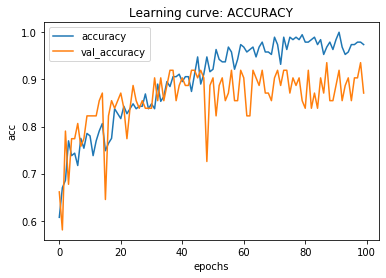

In [26]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: ACCURACY")
plt.show()

# Plot losses

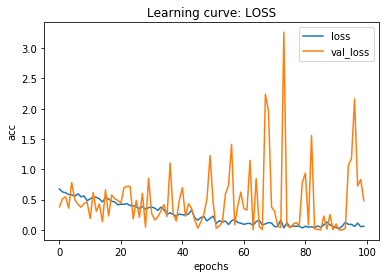

In [27]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: LOSS")
plt.show()

# Save model

In [45]:
model_json = model.to_json()
with open("C:\MyLearnings\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\BaselineModel\\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:\MyLearnings\\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\BaselineModel\\model.h5")
print("Saved model to disk")

Saved model to disk


# Inference
Alas! Our baseline model could only achieve an accuracy o about 80%
So lets try Transfer learning . I'll take VGG 16 model...............

# Fine Tuning VGG16 model

In [19]:
input_tensor = Input(shape=(224, 224, 3))
vgg_model = vgg16.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# Make sure that the pre-trained bottom layers are not trainable
for layer in vgg_model.layers:
    layer.trainable = False
    
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)



# Do not forget to compile it
adma_opt= keras.optimizers.Adam(learning_rate= 1e-3)
custom_model.compile(loss='binary_crossentropy',
                     optimizer=adma_opt,
                     metrics=['accuracy'])
print("Model compiled")
custom_model.summary()
model = custom_model

Model compiled
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 

C:\Users\Ramya\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [20]:

history = custom_model.fit_generator(training_set,  epochs = 70, validation_data = test_set)

Epoch 1/70
24/24 [==============================] - 12s 519ms/step - loss: 0.7944 - accuracy: 0.6492 - val_loss: 0.4823 - val_accuracy: 0.7742
Epoch 2/70
24/24 [==============================] - 13s 547ms/step - loss: 0.5676 - accuracy: 0.7330 - val_loss: 0.3892 - val_accuracy: 0.8710
Epoch 3/70
24/24 [==============================] - 13s 555ms/step - loss: 0.3536 - accuracy: 0.8482 - val_loss: 0.2406 - val_accuracy: 0.7581
Epoch 4/70
24/24 [==============================] - 13s 557ms/step - loss: 0.3797 - accuracy: 0.8325 - val_loss: 0.2102 - val_accuracy: 0.8387
Epoch 5/70
24/24 [==============================] - 13s 556ms/step - loss: 0.2929 - accuracy: 0.8796 - val_loss: 0.2062 - val_accuracy: 0.9194
Epoch 6/70
24/24 [==============================] - 13s 555ms/step - loss: 0.2653 - accuracy: 0.8848 - val_loss: 0.4540 - val_accuracy: 0.9032
Epoch 7/70
24/24 [==============================] - 13s 555ms/step - loss: 0.2194 - accuracy: 0.9162 - val_loss: 0.3655 - val_accuracy: 0.8226

# Plot accuracies

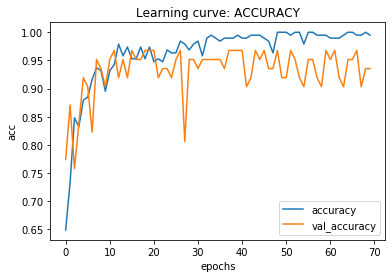

In [21]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: ACCURACY")
plt.show()

# Plot losses

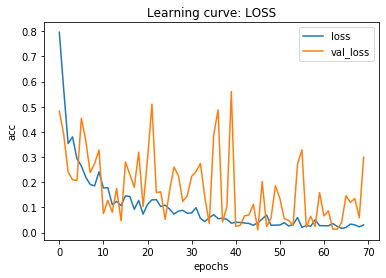

In [22]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: LOSS")
plt.show()

# Save Model

In [23]:
model_json = model.to_json()
with open("C:\MyLearnings\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\TransferLearnedModel\\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:\MyLearnings\\DeepLearning\\Kaggle_Datasets\\BrainMRI\\brain-mri-images-for-brain-tumor-detection\\TransferLearnedModel\\model.h5")
print("Saved model to disk")

Saved model to disk
